> # Customizing1 #

### - Custom loss function ###

Suppose there are some noise data in train set. Then what loss function we should use? MSE gives to excessive penalty at big error. So it can't make an optimal model. And MAE takes time to convergence since it is generous to outliers. And the model not be trained precisely. Then we can make Huber loss. Let's make it.

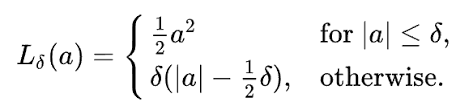

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
def huber_loss(y_pred, y_true):
    error = y_true - y_pred
    smaller = tf.abs(error) <= 1
    small_loss = 0.5 * tf.square(error)
    big_loss = tf.abs(error) - 0.5
    
    return tf.where(smaller, small_loss, big_loss)

It's better to return a tensor which has a loss. Then keras can apply class or sample weight when it's needed.

In [6]:
model = keras.models.load_model("model_A.h5")
model.compile(loss=huber_loss, optimizer='nadam')

In [7]:
model.save("huber_model.h5")

When keras saves the model, it saves function name. So no matter accurs in saving. More generally, we have to map name and class when load custom model.

In [8]:
model = keras.models.load_model("huber_model.h5", custom_objects={"huber_loss" : huber_loss})

Threshold of above fuction is set 1. How we do when we need another threshold value? One method is to make a function that can takes a variable.

In [13]:
def huber(threshhold=1):
    def huber_loss(y_pred, y_true):
        error = y_true - y_pred
        smaller = tf.abs(error) <= threshhold
        small_loss = 0.5 * tf.square(error)
        big_loss = threshhold(tf.abs(error) - 0.5*threshhold)
    
        return tf.where(smaller, small_loss, big_loss)
    return huber_loss

In [14]:
model.compile(loss=huber(2.5), optimizer="nadam")
model.save("huber_threshold.h5")

When saving model, threshold value is not saved. So we should set threshold value when load model.

In [15]:
model = keras.models.load_model("huber_threshold.h5", custom_objects={"huber_fn": huber(2.5)})

This problem is solved by keras loss class and config method.

In [20]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwrags):
        self.threshold = threshold
        super().__init__(**kwrags)
    def call(self, y_pred, y_true):
        error = y_true - y_pred
        smaller = tf.abs(error) <= self.threshold
        small_loss = 0.5 * tf.square(error)
        big_loss = self.threshold(tf.abs(error) - 0.5*self.threshold)
        return tf.where(smaller, small_loss, big_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [21]:
model.compile(loss=HuberLoss(2.5), optimizer="nadam")

In [22]:
model = keras.models.load_model("huber_threshold.h5", custom_objects={"HuberLoss": HuberLoss})

### - Active function, Initialization, Regularizaiton Customizing ###

We can customize most of keras function by similar method. We just write a fuction code with proper input and output. Under code is some examples of them.

In [23]:
## custoom active function

def soft_plus(z):
    return tf.math.log(tf.exp(z)+1.0)

## custom glorot initialization

def cus_glorot(shape, dtype=tf.float32):
    std = tf.sqrt(2. / (shape[0]+shape[1]))
    return tf.random.normal(shape, stddev=std, dtype=dtype)

## custom l1 regularization

def cus_l1(weights):
    return tf.reduce_sum(tf.abs(0.01*weights))

## custom positive constraint

def cus_positive_weight(weights):
    return tf.where(weights < 0 , tf.zeros_like(weights), weights)

These made functions can be used like normal function.

In [24]:
layer = keras.layers.Dense(30, activation=soft_plus, kernel_initializer=cus_glorot,
                          kernel_regularizer=cus_l1, kernel_constraint=cus_positive_weight)

If the functions have hyperparameter to save with, just inherit proper class.

### - Custom Metic

Loss and metric are not conceptually different. Loss is used for gradient descent. So it is differentiable at all point. People should not understand this function. In contrary, metric is used for evaluating. So people should understand it easily.

But making custom metric is same with making custom loss. Previous huber function works well in metric.

In [25]:
model.compile(loss="mse", optimizer="nadam", metrics=[huber(2.0)])